# an emission spectrum  check CO



In [1]:
#
#   Current Status: Feb. 23th (2021)
#
#   OK: forward JVP / HML RT alpha as a free parameter
#   Not work: primitive backward / alpha as a free parameter
#   Not implemented yet: VJP backward (something wrong for NumPyro) 
#
#   Current fiducial model: forward JVP
#   Updates: 1st sanity check with petit (Feb.23/2021)
#
#   ToDo:
#   Q(T) TIPS
# 

In [2]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [4]:
N=400
wav=np.linspace(22945,22985,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

alpha_in=0.02
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = 1500.*(Parr/Parr[-1])**alpha_in

#loading molecular database (HITRAN2012/CO)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2010.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

In [5]:
from exojax.utils.chopstacks import buildwall 
wParr=buildwall(Parr)
dParr=wParr[1:]-wParr[0:-1]

In [6]:
#partition function ratio
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCO_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
qr=mdbCO_hitran.Qr(Tarr)

In [7]:
#partitioning Q(T) for each line
qt=np.zeros((NP,len(mdbCO.isoid)))
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    for ilayer in range(NP):
        qt[ilayer,mask]=qr[ilayer,idx]

In [8]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=28.01 #molecular mass
mmr=0.01 #mass mixing ratio

g=1.e5 # gravity cm/s2
Xco=np.ones_like(Tarr)*mmr*mmw/molmass 
tfac=1.e3*Xco/(mmw*m_u*g)  

In [9]:
vmr=mmr*mmw/molmass 

In [10]:
vmr

0.0008318457693680828

In [11]:

Tref=296.0
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr*vmr, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,molmass)

In [12]:
nu0=mdbCO.nu_lines
numatrix=make_numatrix0(nus,nu0)
xsm=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

## cheking d tau and contribution function

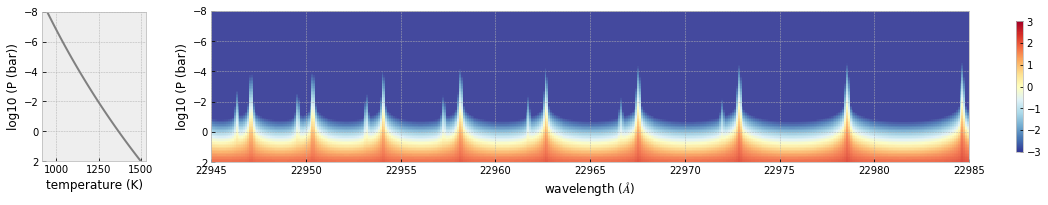

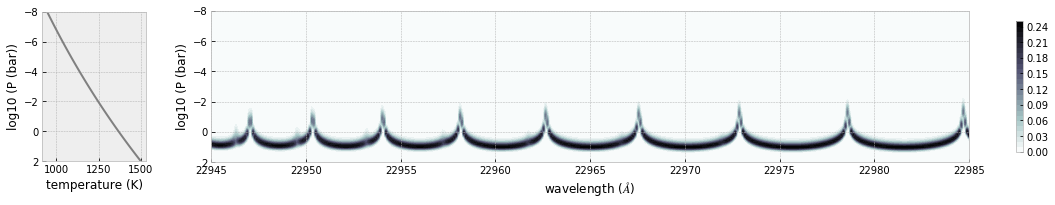

In [13]:
dtauM=dParr[:,None]*xsm*tfac[:,None]
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
#plt.savefig("../../documents/figures/plottau.png")
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") 
#plt.savefig("../../documents/figures/plotcf.png")

In [14]:
gi=planck.piBarr(Tarr,nus)

In [15]:
len(nus), np.shape(xsm)[1]

(400, 400)

In [16]:

@jit
def rt_twos(xsm,tfac,gi,dParr):
    """Radiative Transfer using 2 stream+AS (Helios-R1 type)
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """
    Nnus=np.shape(xsm)[1]
    
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228
    
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    dtauM2=dtauM**2
    dtauM3=dtauM**3
    dtauM4=dtauM**4
    dtauM5=dtauM**5
    ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    ep1B=jnp.exp(-dtauM)/dtauM*\
    (dtauM4+B1*dtauM3+B2*dtauM2+B3*dtauM+B4)/\
    (dtauM4+C1*dtauM3+C2*dtauM2+C3*dtauM+C4)
    ep=jnp.where(dtauM<=1.0, ep1A, ep1B)

    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+dtauM2*ep
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(Nnus)
    Qv=(1-TransM)*gi
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(Nnus)
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    ccgs=29979245800.0 #c (cgs)
    return Fx/ccgs

In [17]:
@jit
def rt_naive(xsm,tfac,gi,dParr):
    """Radiative Transfer without considering mu dependence
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    tau=jnp.cumsum(dtauM,axis=0)
    Fx=jnp.sum(gi*jnp.exp(-tau)*dtauM,axis=0)
    ccgs=29979245800.0
    return Fx/ccgs

In [18]:
# using scipy E1
from scipy.special import expn
def rt_twos_expn(xsm,tfac,gi,dParr):
    """Radiative Transfer using 2 stream+scipy.special.expn 
    
    Notes:
        This RT uses scipy.special.expn. Hence, JIT does not work. 
        Consider to use rt_twos instead. 
    
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """   
    Nnus=np.shape(xsm)[1]
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    TransMx=2.0*expn(3,dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(Nnus)
    Qv=(1-TransM)*gi
    
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(Nnus)
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    ccgs=29979245800.0
    return Fx/ccgs

In [19]:
%timeit Fx0=rt_twos(xsm,tfac,gi,dParr)

220 µs ± 53.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
gie=planck.piBarr(jnp.array([Tarr[-1]]),nus)
gie=planck.piBarr(jnp.array([3000.0]),nus)

In [21]:
gie

DeviceArray([[436638.  , 436639.25, 436640.4 , 436641.66, 436642.8 ,
              436644.  , 436645.16, 436646.3 , 436647.47, 436648.72,
              436649.9 , 436650.94, 436652.12, 436653.38, 436654.56,
              436655.72, 436656.97, 436658.12, 436659.38, 436660.4 ,
              436661.66, 436662.8 , 436664.06, 436665.12, 436666.28,
              436667.5 , 436668.66, 436669.8 , 436671.1 , 436672.25,
              436673.47, 436674.56, 436675.75, 436676.9 , 436678.2 ,
              436679.22, 436680.5 , 436681.66, 436682.84, 436683.94,
              436685.1 , 436686.28, 436687.47, 436688.62, 436689.9 ,
              436691.06, 436692.22, 436693.38, 436694.5 , 436695.78,
              436696.94, 436697.97, 436699.25, 436700.44, 436701.62,
              436702.7 , 436703.9 , 436705.16, 436706.3 , 436707.5 ,
              436708.75, 436709.94, 436711.12, 436712.22, 436713.38,
              436714.6 , 436715.78, 436716.94, 436718.1 , 436719.22,
              436720.47, 436721.53

In [22]:

@jit
def rt_twos_bottom(xsm,tfac,gi,dParr,gie):
    """Radiative Transfer using 2 stream+AS (Helios-R1 type)
    
    Notes:
       
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        gie: bottom layer black body
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """
    Nnus=np.shape(xsm)[1]
    
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228
    
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    dtauM2=dtauM**2
    dtauM3=dtauM**3
    dtauM4=dtauM**4
    dtauM5=dtauM**5
    ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    ep1B=jnp.exp(-dtauM)/dtauM*\
    (dtauM4+B1*dtauM3+B2*dtauM2+B3*dtauM+B4)/\
    (dtauM4+C1*dtauM3+C2*dtauM2+C3*dtauM+C4)
    ep=jnp.where(dtauM<=1.0, ep1A, ep1B)

    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+dtauM2*ep
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=gie#jnp.zeros(Nnus)
    Qv=(1-TransM)*gi
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(Nnus)
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    ccgs=29979245800.0 #c (cgs)
    return Fx/ccgs

In [23]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=28.01 #molecular mass
mmr=0.001 #mass mixing ratio

g=1.e5 # gravity cm/s2
Xco=np.ones_like(Tarr)*mmr*mmw/molmass 
tfac=1.e3*Xco/(mmw*m_u*g)  

tfac=tfac
Fx0n=rt_naive(xsm,tfac,gi,dParr)
Fx0=rt_twos(xsm,tfac,gi,dParr)
#Fx0_En=rt_twos_expn(xsm,tfac,gi,dParr)

In [24]:
Smax=(np.max(SijM,axis=0))
mask=np.log10(Smax)>-22
len(Smax[mask])

143

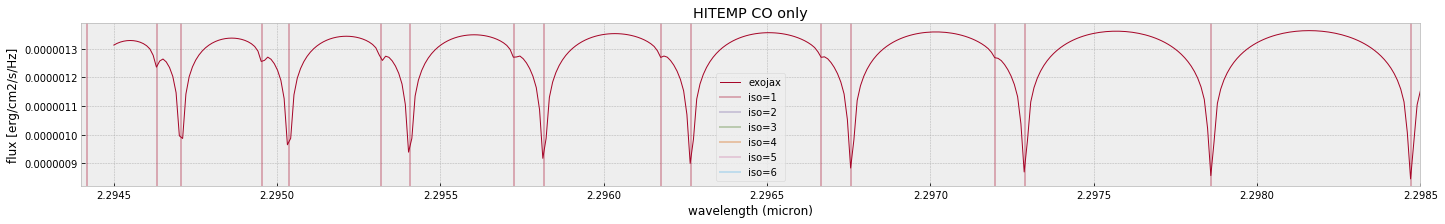

In [26]:
fig=plt.figure(figsize=(24,3))
ax=fig.add_subplot(111)
plt.plot(1.e4/nus,Fx0,lw=1,alpha=1.0,label="exojax",color="C1")
#plt.plot(1.e4/nus,Fx0n,lw=1,alpha=1.0,label="exojax naive",color="C2")
#plt.plot(1.e4/nus,Fx0_En,lw=1,alpha=1.0,label="exojax En",color="C3")
#plt.plot(dat["WAV"],dat["VAL"],lw=1,alpha=0.9,ls="dashed",label="petitRadtran")
### ISO LINE
if True:
    crit=-24
    for iso in mdbCO.uniqiso:
        mask=(mdbCO.isoid==iso)*(np.log10(Smax)>crit)
        wiso=1.e4/nu0[mask]
        for w in wiso:
            plt.axvline(w,color="C"+str(iso),alpha=0.3)

    #iso just for label
    for iso in mdbCO.uniqiso:
        plt.axvline([1.0],color="C"+str(iso),alpha=0.3,label="iso="+str(iso))
###

#plt.xlim(2.38,2.39)
#plt.xlim(2.372,2.385)
plt.xlim(2.2944,2.29850)
plt.xlabel("wavelength (micron)")
plt.ylabel("flux [erg/cm2/s/Hz]")
plt.title("HITEMP CO only")
plt.legend()
#plt.savefig("test_CO.png", bbox_inches="tight", pad_inches=0.0)

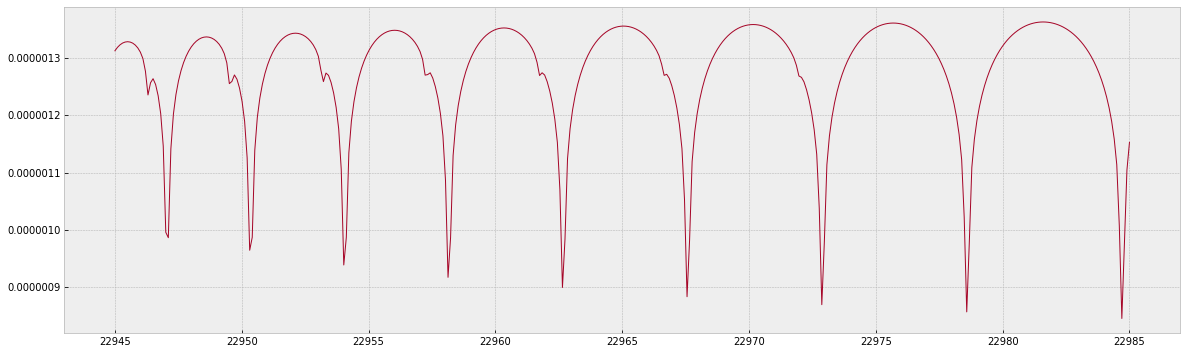

In [27]:
fig=plt.figure(figsize=(20,6.0))

plt.plot(wav[::-1],Fx0,lw=1,color="C1")
#plt.plot(wav[::-1],Fx1,lw=1,color="C2")
#plt.yscale("log")
#plt.xlim(22950,23300)
#plt.ylim(-0.1,2.6)
plt.savefig("highredCO.png")

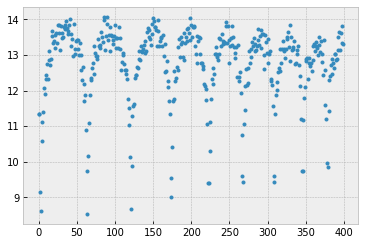

In [28]:
intfac=1.e7
sigin=0.25
N=len(Fx0)
data=Fx0*intfac+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [29]:
vgamma_hitran=jit(vmap(gamma_hitran,(0,0,0,None,None,None)))
vdoppler_sigma=jit(vmap(doppler_sigma,(None,0,None)))
vSij=jit(vmap(SijT,(0,None,None,None,0)))

In [30]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

/home/kawahara/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [31]:
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228

In [32]:
#dParr[:,None]+np.zeros(np.shape(xsm))

In [33]:
#send molecular database to device
device_gamma_natural=jnp.array(gamma_natural(mdbCO.A))
device_logsij=jnp.array(mdbCO.logsij0)
device_nu_lines=jnp.array(mdbCO.nu_lines)
device_elower=jnp.array(mdbCO.elower)
device_n_air=jnp.array(mdbCO.n_air)
device_gamma_air=jnp.array(mdbCO.gamma_air)
device_gamma_self=jnp.array(mdbCO.gamma_self)
device_relative_Parr=jnp.array(Parr/Parr[-1])
device_Parr=jnp.array(Parr)
device_dParr=jnp.array(dParr[:,None]+np.zeros(np.shape(xsm)))
device_zerov=jnp.zeros(len(nus))
device_onev=jnp.ones(len(nus))

In [34]:
epsilon=1.e-20
ccgs=29979245800.0 
intfaccgs=intfac/ccgs

def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(0.3))
    #T0 = numpyro.sample('T0', dist.Uniform(1400,1600))
    nu0 = numpyro.sample('nu0', dist.Uniform(-0.3,0.3))
    #alpha=0.02 
    alpha = numpyro.sample('alpha', dist.Uniform(0.019,0.021))

    #model
    #numatrix0=make_numatrix0(nu,nu_lines)
    Tarr = 1500.*(device_relative_Parr)**alpha 
    #line computation
    SijM=vSij(Tarr,device_logsij,device_nu_lines,device_elower,qt)
    gammaLM = vgamma_hitran(device_Parr,Tarr,device_Parr,\
                            device_n_air, device_gamma_air, device_gamma_self) \
    + device_gamma_natural #uncomment if you inclide a natural width
    sigmaDM=vdoppler_sigma(device_nu_lines,Tarr,molmass)
    #gi = piB(Tarr,nusmean)
    gi = planck.piBarr(Tarr,nus)
    
    xsm=cxsmatrix(numatrix-nu0,sigmaDM,gammaLM,SijM)    
    #dtauM=dParr[:,None]*(xsm)*tfac
    dtauM=device_dParr*(xsm)*tfac[:,None]+epsilon
    mdtauM=1.0/(dtauM)
    mdtauM2=mdtauM*mdtauM
    mdtauM3=mdtauM*mdtauM2
    mdtauM4=mdtauM2*mdtauM2
    dtauM2=dtauM*dtauM
    dtauM3=dtauM2*dtauM
    dtauM4=dtauM2*dtauM2
    dtauM5=dtauM4*dtauM

    ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    ep1A=ep1A*dtauM2
    
    ep1B=jnp.exp(-dtauM)*\
    (1.0+B1*mdtauM+B2*mdtauM2+B3*mdtauM3+B4*mdtauM4)/\
    (1.0+C1+mdtauM+C2*mdtauM2+C3*mdtauM3+C4*mdtauM4)
    ep1B=ep1B*dtauM
    
    ep=jnp.where(dtauM<=1.0, ep1A, ep1B)
    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+ep
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    #Qv=(1.0-TransM)*gi[:,None]
    Qv=(1.0-TransM)*gi
    Qv=jnp.vstack([Qv,device_zerov])
    TransM=jnp.vstack([device_onev,TransM])
    mu=intfaccgs*A*(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))

    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [35]:
#nus, numatrix0 -> device?

In [36]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

#kernel = NUTS(model)
kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nus, y=data)
mcmc.print_summary()

sample: 100%|██████████| 300/300 [20:31<00:00,  2.20s/it, 63 steps of size 2.91e-02. acc. prob=0.97]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.00      0.00      1.00      1.00      1.01     36.04      1.00
     alpha      0.02      0.00      0.02      0.02      0.02     35.45      1.00
       nu0     -0.00      0.00     -0.00     -0.00     -0.00    201.32      1.00
     sigma      0.26      0.01      0.26      0.24      0.28    178.86      1.01

Number of divergences: 0


In [37]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nus
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)

In [38]:
hpdi_mu = hpdi(predictions["y"], 0.9)

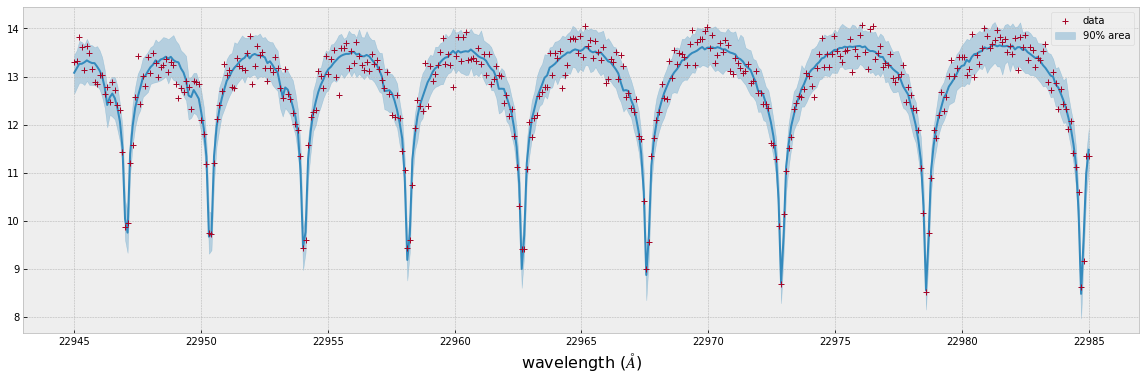

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))


#plt.plot(wav[::-1],Fx0,lw=1,color="C1",label="in")
ax.plot(wav[::-1],median_mu,color="C0")
ax.plot(wav[::-1],data,"+",color="C1",label="data")
ax.fill_between(wav[::-1], hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_CO_emission.png")
plt.show()

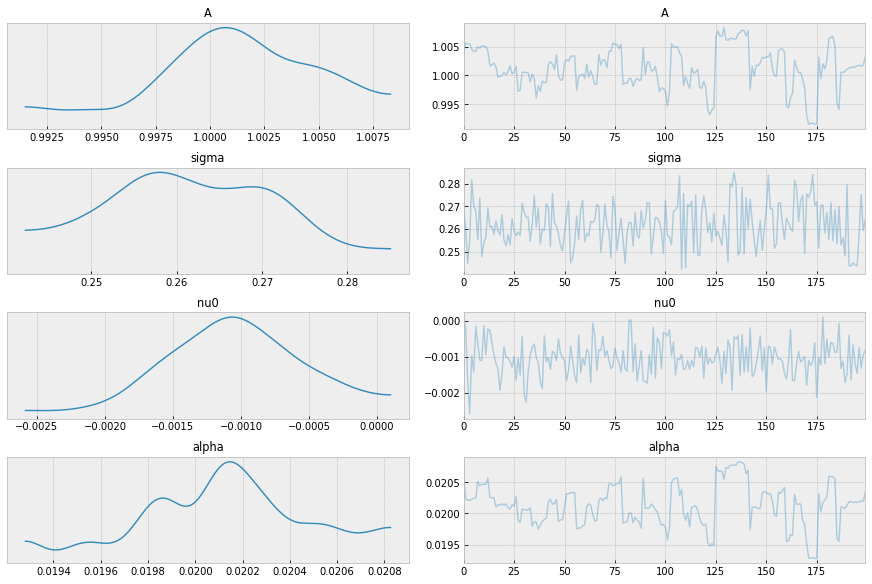

In [40]:
import arviz
arviz.plot_trace(mcmc, var_names=["A","sigma","nu0","alpha"])
plt.show()

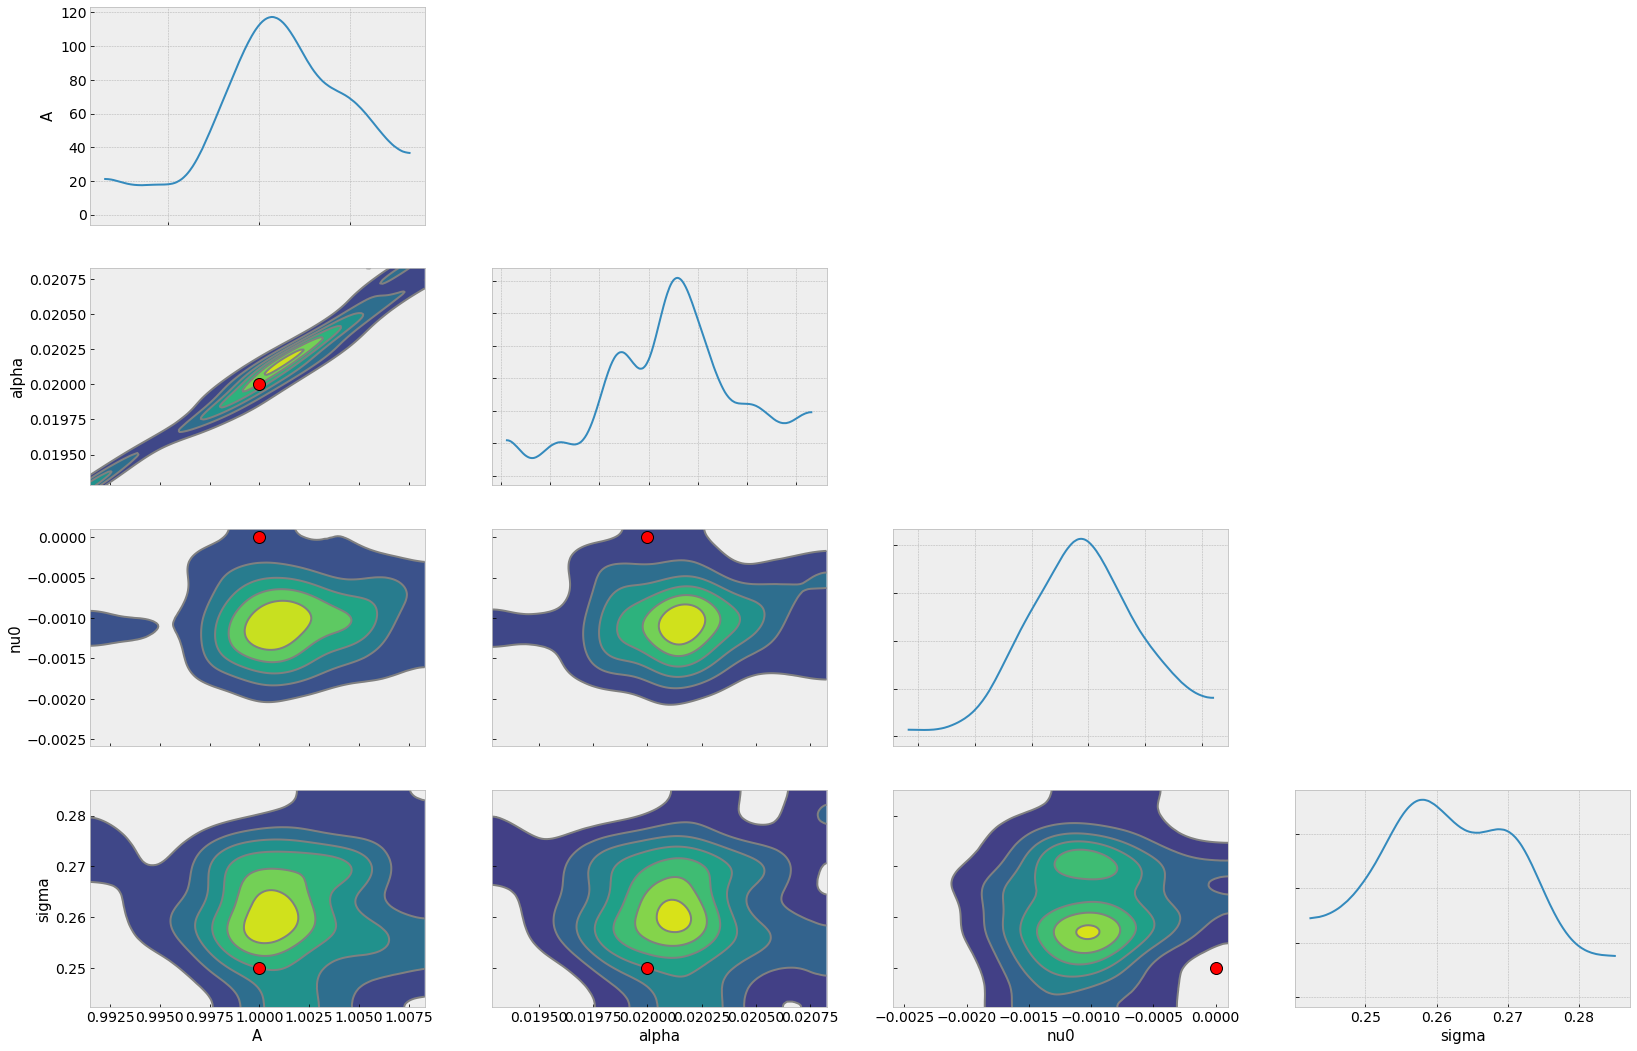

In [43]:
refs={}
refs["A"]=1.0
#refs["sD"]=sDfix
#refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=0.0
refs["alpha"]=0.02
#refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("testCO.png")
plt.show()

In [ ]:
sigin

## LA RT (class)

In [17]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.dParr=dParr
jaxrt.NP=NP
jaxrt.k=k

In [21]:
#run using flatten() and reshape()
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.run(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [20]:
#runx (using vmap)
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.runx(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [24]:
np.shape(numatrix)

(1000, 1000)

In [22]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [02:49<00:00, 17.74it/s, 7 steps of size 5.12e-01. acc. prob=0.91]    



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.10      0.00     -0.10     -0.10     -0.10   2608.95      1.00
        gL      1.06      1.04      0.75      0.01      2.38   2098.59      1.00
       nu0      0.75      0.07      0.75      0.65      0.88   2031.69      1.00
        sD      0.99      1.00      0.70      0.00      2.24   2271.31      1.00
     sigma     10.04      0.23     10.03      9.66     10.40   2238.15      1.00

Number of divergences: 0


## Note (Jan 16 2021): 
currently runx (using vmap) is ~ 2 times slower than run (using flatten() and reshape)

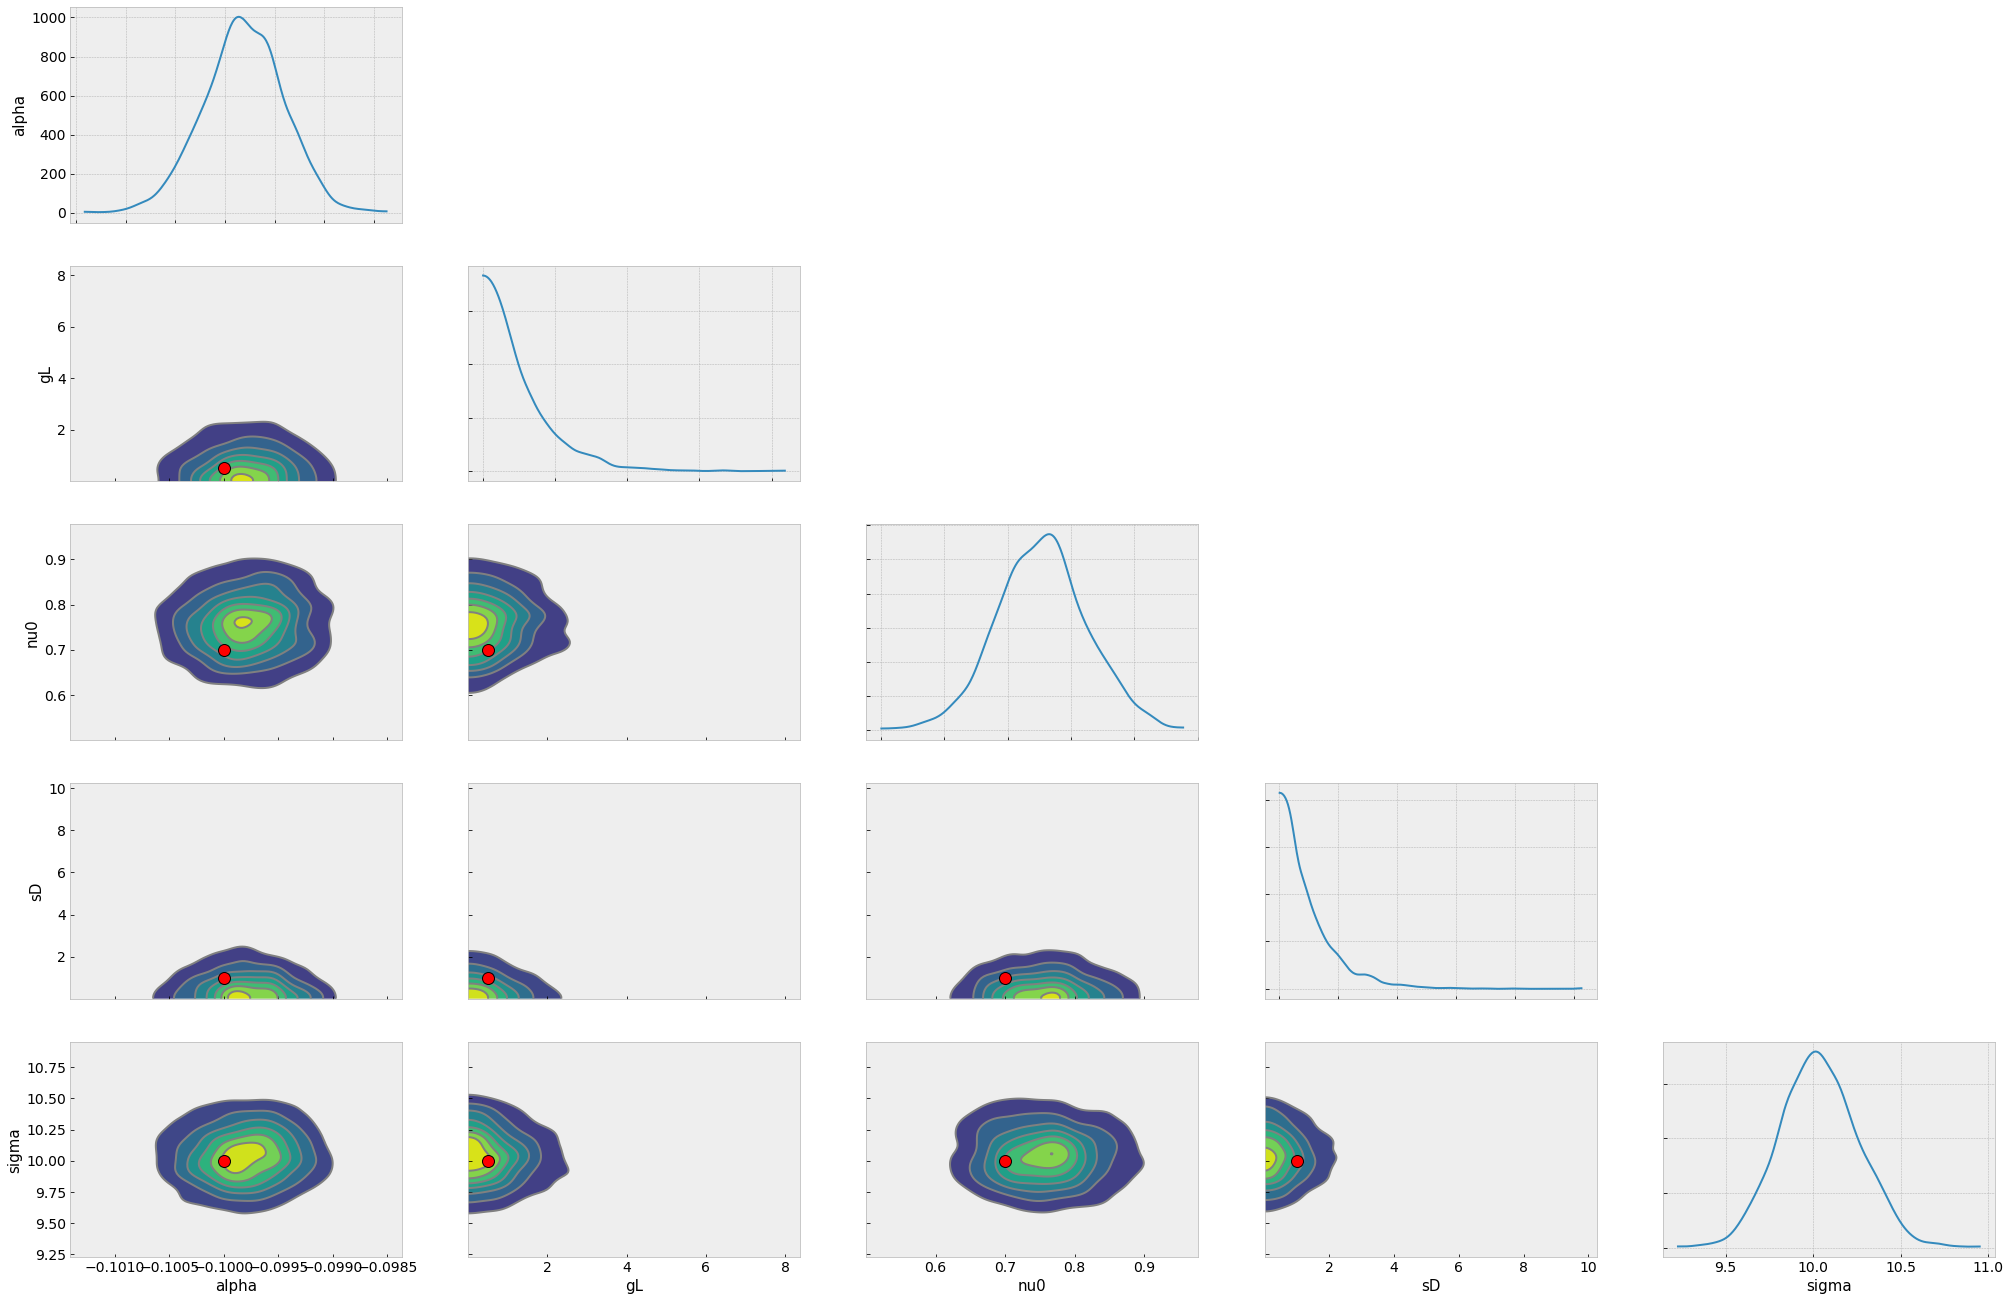

In [23]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=10.0
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

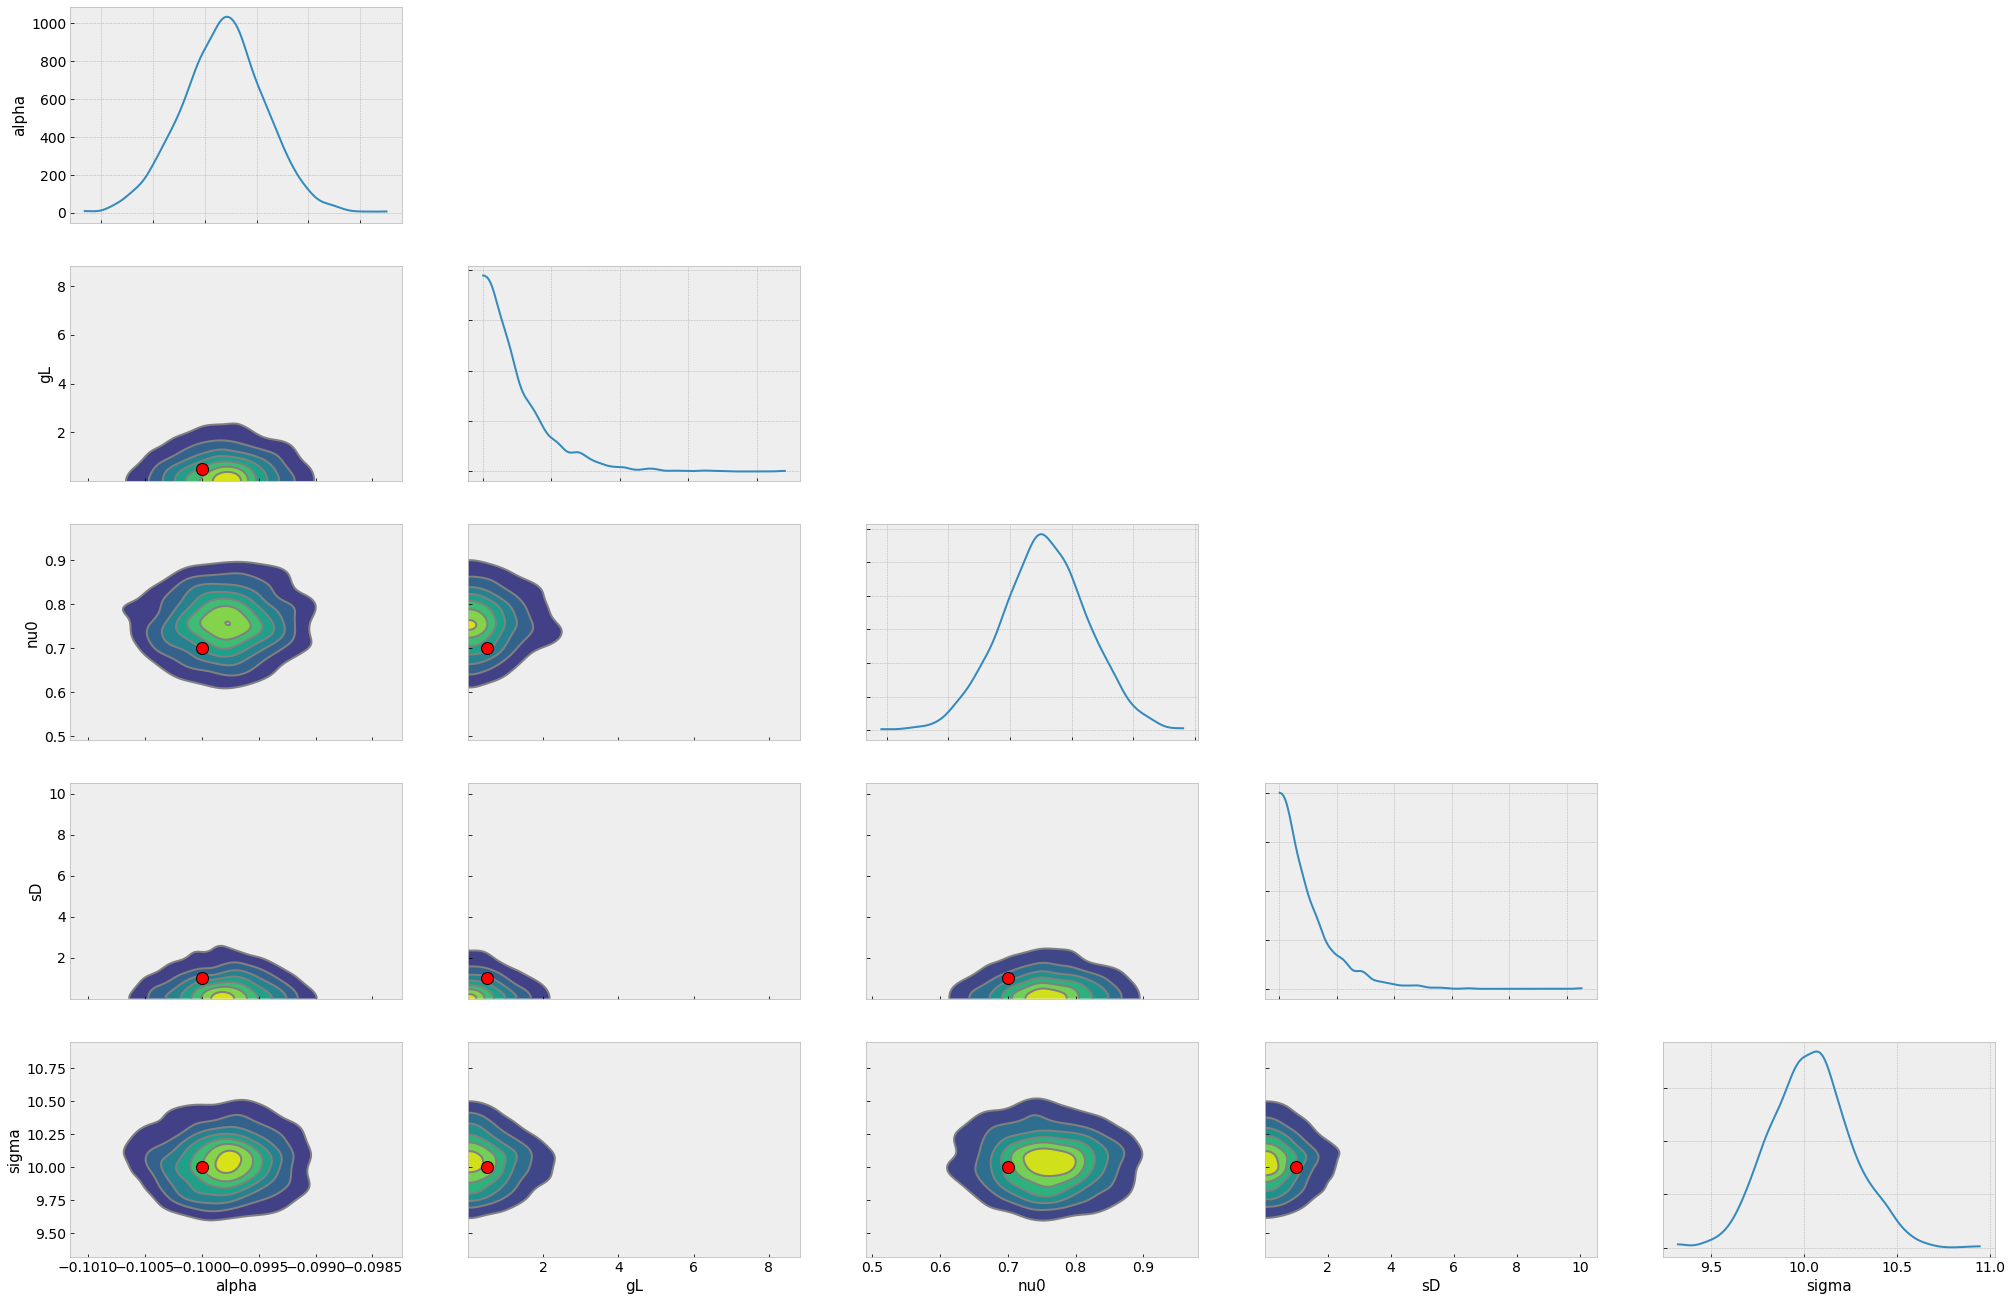

In [23]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [36]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

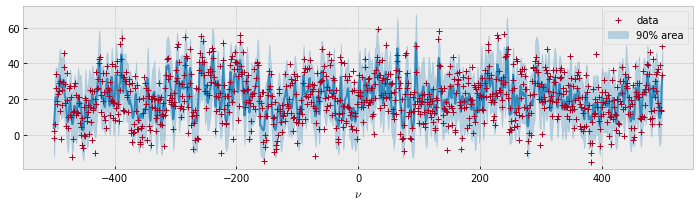

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()

## Layer scan

In [9]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.NP=NP
jaxrt.k=k

In [10]:
numic=0.5
F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
init=[F0,Parr[0],0.7,1.0,0.5]
jaxrt.Tarr=Tarr
%timeit jaxrt.layerscan(init)

2.93 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


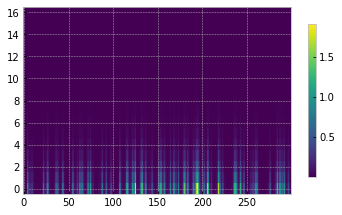

In [11]:
F0=jnp.zeros(len(nuarr))
init=[F0,Parr[0],0.7,1.0,0.5]
FP,tauarr=scan(jaxrt.add_layer,init,Tarr.T,NP)

fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow(tauarr)
plt.colorbar(c,shrink=0.7)
ax.set_aspect(0.7/ax.get_data_ratio())
plt.gca().invert_yaxis()

In [12]:
from jax import grad
F0=jnp.zeros(len(nuarr))
#F0=0.0
init=[F0,Parr[0],0.7,1.0,0.5]
#scan(add_layer,init,Tarr,NP)

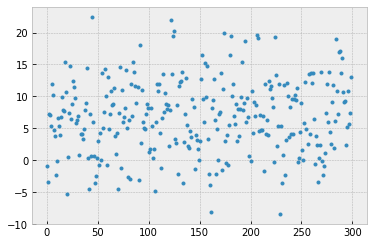

In [16]:
@jit
def g(xs):
    """
    Params: 
      xs: free parameters
    """
    Tarr=xs
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #F0=0.0
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(jaxrt.add_layer,init,Tarr,NP)
    return FP[0]*3.e4

sigin=5.0
data=g(Tarr)+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [17]:
#jaxrt.Tarr=Tarr

#probabilistic model using numpyro
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    numic=0.5
    nuarr=nu
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    init=[F0,Parr[0],nu0,sD,gL]
    jaxrt.Tarr=Tarr
    mu=jaxrt.layerscan(init)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [13:50<00:00,  2.94it/s, 15 steps of size 3.07e-01. acc. prob=0.90]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        gL      0.76      0.37      0.75      0.18      1.38    665.32      1.00
       nu0      0.47      0.21      0.48      0.13      0.81   1239.00      1.00
        sD      1.04      0.43      1.05      0.24      1.65    645.96      1.00
     sigma      4.88      0.20      4.87      4.55      5.19   1361.18      1.00

Number of divergences: 57


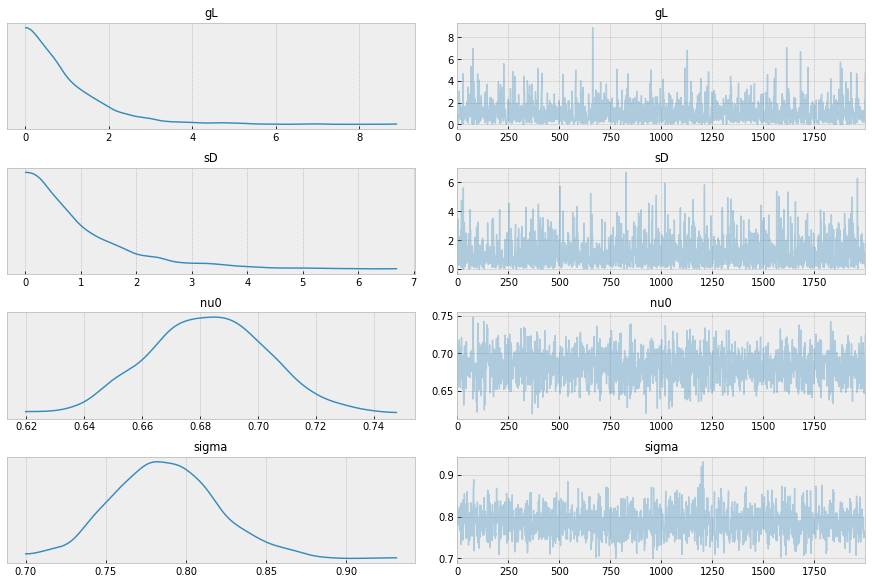

In [22]:
import arviz
arviz.plot_trace(mcmc, var_names=["gL", "sD","nu0","sigma"])
plt.show()

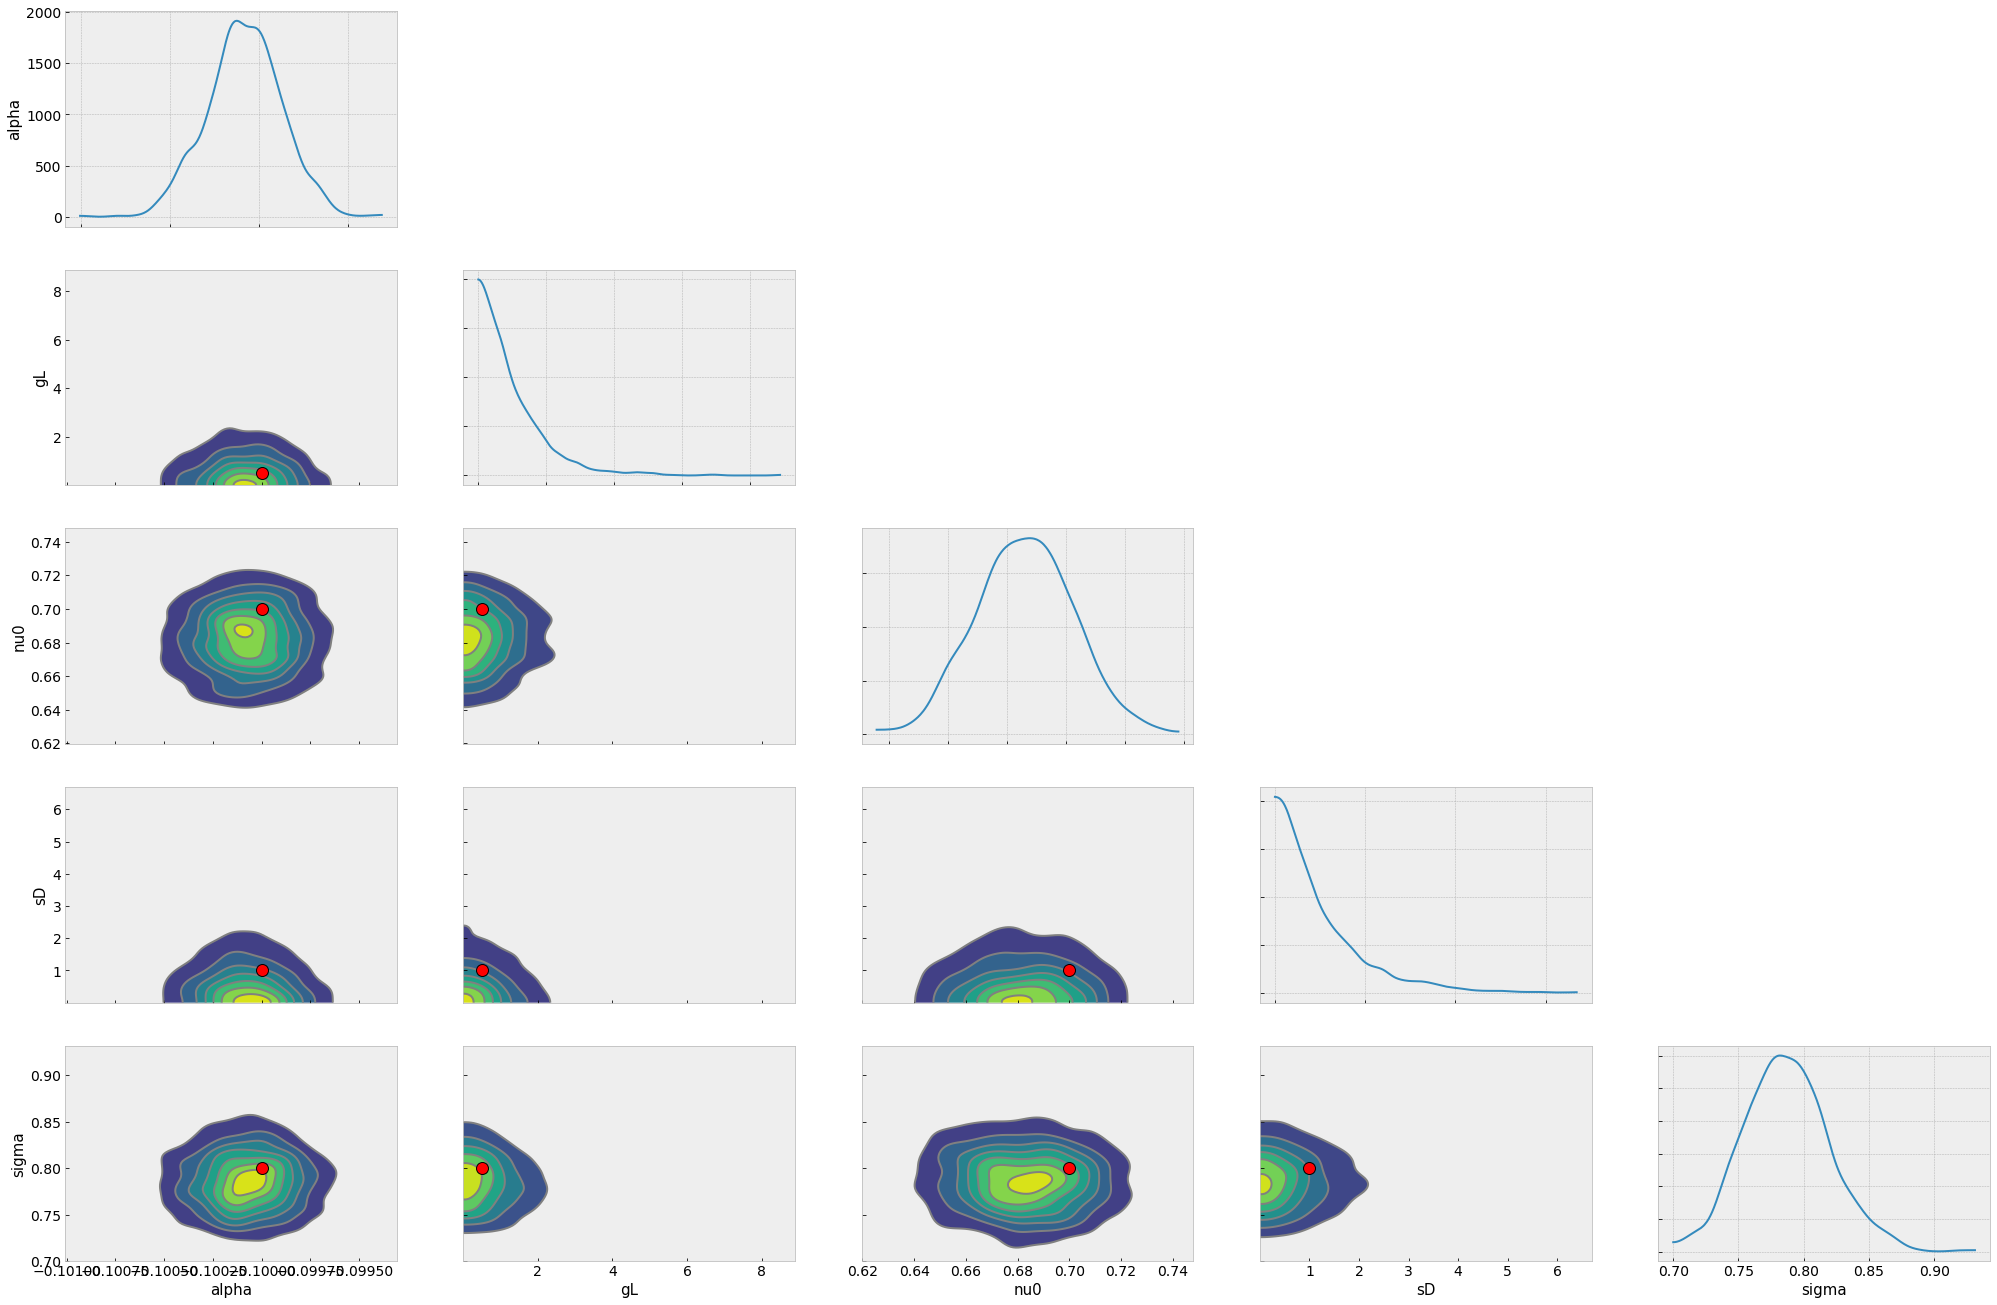

In [24]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [25]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

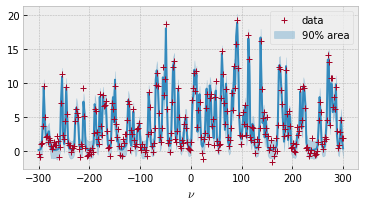

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()